需要解决一个复杂的问题，例如检测高分辨率图像中的数百种物体，可能需要训练更深的ANN，也许有10层或更多层，每层包含数百个神经元，有成千上万个连接。训练深度神经网络不简单。

以下是可能会遇到的一些问题：
- 在训练过程中反向流过DNN时，可能会遇到梯度变得越来越小或越来越大的问题。这两个问题都使较低的层很难训练。
- 对于如此大的网络，可能没有足够的训练数据，或者做标签的成本太高。
- 训练速度可能会非常缓慢。
- 具有数百万个参数的模型会有很高的风险过拟合训练集，尤其是在没有足够的训练实例或噪声太大的情况下。

将研究这些问题，并介绍解决这些问题的技术。首先探索梯度消失和梯度爆炸问题及它们的一些受欢迎的解决方法。接下来，将研究迁移学习和无监督预训练，即使在标签数据很少的情况下，它们也可以帮助你完成复杂的任务。然后，将讨论可以极大加速训练大型模型的各种优化器。最后，我们将介绍一些流行的针对大型神经网络的正则化技术。使用这些工具，就能够训练非常深的网络。

## 梯度消失和梯度爆炸问题

反向传播算法的第二阶段从输出层到输入层，沿途传播误差梯度。一旦算法计算出代价函数相对于网络中每个参数的梯度，就可以通过梯度下降步骤使用这些梯度来更新每个参数。

随着算法向下传播到较低层，梯度通常会越来越小。因此，梯度下降更新使较低层的连接权重保持不变，训练不能收敛到一个最优解。这称为梯度消失问题。在某些情况下，可能会出现相反的情况：梯度可能会越来越大，各层需要更新很大的权重直到算法发散为止。这是梯度爆炸问题，更笼统地说，深度神经网络受梯度不稳定的影响，不同的层可能以不同的速度学习。

查看sigmoid激活函数，可以看到，当输入变大（负数或正数）时，该函数会以0或1饱和，并且导数非常接近0（即曲线在两个极端处都很平坦）。因此，当反向传播开始时，它几乎没有梯度可以通过网络传播回去，并且随着反向传播通过顶层向下传播，存在的少量梯度会不断被稀释，因此对于较低层来说，实际上什么也没有留下

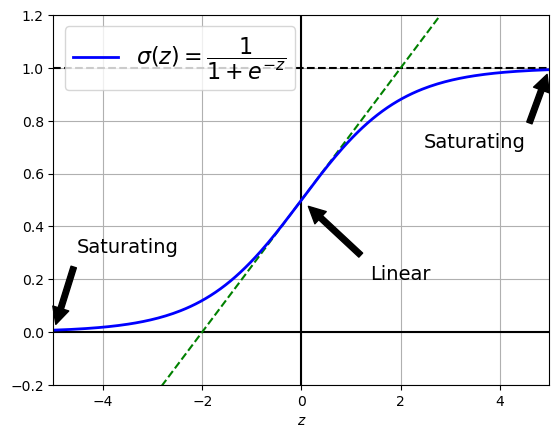

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

### Glorot初始化和He初始化

Glorot和Bengio在他们的论文中提出了一种能显著缓解不稳定梯度问题的方法。他们指出，需要让信号在两个方向上正确流动：在进行预测时，信号正向流动；在反向传播梯度时，信号反向流动。我们既不希望信号消失，也不希望它“爆炸”并“饱和”。

为了使信号正确流动，作者认为，需要让每层输出的方差等于其输入的方差，并且在反方向时需要让梯度流过某层之前和之后具有相同的方差。

除非该层具有相等数量的输入和输出（这些数字称为该层的扇入和扇出），否则实际上不可能同时保证两者，但是Glorot和Bengio提出了一个很好的折中方案，该方案已在实践中证明能够很好地发挥作用：必须按照公式随机初始化每层的连接权重，这种初始化策略称为Xavier初始化或者Glorot初始化，以论文第一作者的名字命名。

随机初始化权重公式：使用sigmoid激活函数时，均值为0，方差为1/fan_avg的正态分布 或 -r和+r之间的均匀分布，其中r=sqrt(3/fan_avg), 其中fan_avg = (fan_in + fan_out) / 2

如果在公式中用`fan_in`替换`fan_avg`，则会得到Yann LeCun在20世纪90年代提出的初始化策略。他称之为**LeCun初始化**。

当`fan_in = fan_out`时，LeCun初始化等效于Glorot初始化。

研究人员花了十多年的时间才意识到这一技巧的重要性: 使用Glorot初始化可以大大加快训练速度，这是导致深度学习成功的实践之一。


一些论文为不同的激活函数提供了类似的策略。这些策略的差异仅在于方差的大小以及它们使用的是`fan_avg`还是`fan_in`，如表中所示（对于均匀分布，只需使用$-\sqrt{3\sigma^2}$到$\sqrt{3\sigma^2}$的范围）。为ReLU激活函数及其变体提出的初始化策略称为**He初始化**或**Kaiming初始化**，以论文第一作者[何恺明] 名字命名。对于SELU，使用Yann LeCun的初始化方法，最好使用正态分布。

**表：每种激活函数的初始化参数**

| 初始化方法      | 激活函数                          | $\sigma^2$ (方差)             |
|-----------------|-----------------------------------|-----------------------------|
| Glorot 初始化   | None、tanh、sigmoid、softmax      | $1/\text{fan}_{\text{avg}}$ |
| He 初始化       | ReLU、Leaky ReLU、ELU、GELU、Swish、Mish | $2/\text{fan}_{\text{in}}$  |
| LeCun 初始化    | SELU                              | $1/\text{fan}_{\text{in}}$  |

默认情况下，Keras使用具有均匀分布的Glorot初始化。创建层时，可以通过设置`kernel_initializer="he_uniform"`或`kernel_initializer="he_normal"`来将其更改为He初始化：

In [2]:
import tensorflow as tf
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

或者，可以使用VarianceScaling初始化器获得表中列出的任何初始化以及更多。例如，如果想用均匀分布并且基于fan_avg（而不是fan_in）进行He初始化，则可以使用下面的代码：

In [3]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer=he_avg_init)

### 更好的激活函数

Glorot和Bengio在2010年的论文中提出的一项见解是，梯度不稳定的问题部分原因是激活函数选择不当。在此之前，大多数人都认为使用类似sigmoid的激活函数必定是一个好选择。

但是事实证明，其他激活函数在深度神经网络中的表现要更好，尤其是ReLU激活函数，主要是因为它不会在正值输入下饱和，而且它的计算速度非常快。

不幸的是，ReLU激活函数并不完美。它有一个被称为“濒死的ReLUs”的问题：在训练过程中，某些神经元实际上“死亡”了，这意味着它们停止输出除0以外的任何值。在某些情况下，可能会发现网络中一半的神经元都“死亡”了，特别是使用较大的学习率时。当神经元的权重被调整为ReLU函数的输入（即神经元输入的加权和加上它的偏置项）对于训练集中的所有实例都为负时，神经元就会“死亡”。当发生这种情况时，它只会继续输出0，梯度下降不会再影响它，因为ReLU函数的输入为负时其梯度为零。

要解决此问题，你可能需要使用ReLU函数的变体，例如leaky ReLU。

(注意：除非神经元在第一个隐藏层，否则“死亡”的神经元可能会复活：梯度下降会调整各层中的神经元，使得“死亡”神经元输入的加权和再次为正）

#### leaky Relu

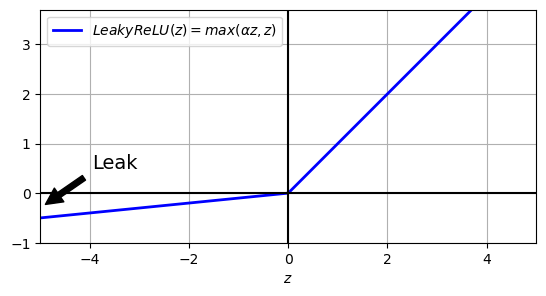

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

该函数定义为 $\text{leakyReLU}_\alpha(z) = \max(\alpha z, z)$。超参数 $\alpha$ 定义函数“泄漏”的程度：它是 $z < 0$ 时函数的斜率。$z < 0$ 时的斜率确保 leaky ReLU 永不“死亡”，它们可能会陷入长时间的“昏迷”，但是有机会“醒来”。

2015年的一篇论文比较了ReLU激活函数的几种变体，其结论之一是leaky变体要好于严格的ReLU激活函数。实际上，设置 $\alpha = 0.2$（大泄漏）似乎比 $\alpha = 0.01$（小泄漏）能产生更好的性能。

该论文还对**随机性leaky ReLU (RReLU)** 进行了评估，在训练过程中在给定范围内随机选择 $\alpha$，在测试过程中将其固定为均值。RReLU的表现也相当不错，似乎可以充当正则化函数，降低了过度拟合训练集的风险。

该论文评估了**参数化leaky ReLU (PReLU)**，其中 $\alpha$ 可以在训练期间学习（不是超参数），它像其他任何参数一样，可以通过反向传播进行修改。据报道，PReLU在大型图像数据集上的性能明显优于ReLU，但是在较小的数据集上，它存在过度拟合训练集的风险。

In [ ]:
# Keras在tf.keras.layers包中包含LeakyReLU和PReLU类
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3


dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")   # Relu变体使用He初始化

In [7]:
# 将LeakyReLU单独用作模型中的层，和之前写activation = leak_relu,对比，对训练和预测没有影响
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # 激活函数作为一个独立的层
    # [...]  # more layers
])

#### ELU和SELU

ReLU，leaky ReLU都有不是光滑函数的缺点：它们的导数会突然变化，这种不连续性会使梯度下降在最优值附近反弹，并减慢收敛速度。所以关注ReLU激活函数的一些平滑变体：从ELU和SELU开始



2015年提出了一种新的激活函数，称为**指数线性单元 (ELU)**，在作者的实验中其性能优于所有ReLU变体：训练时间减少，神经网络在测试集上表现更好。公式显示了该激活函数的定义。


$$
\text{ELU}_{\alpha}(z) =
\begin{cases}
\alpha(\exp(z)-1), & z < 0 \\
z, & z \geq 0
\end{cases}
$$


ELU激活函数看起来很像ReLU函数，但有几个主要区别：

- **负值输出**：当 \( z < 0 \) 时，它取负值，这使该单元的平均输出接近于0，有助于缓解梯度消失问题。超参数 \( alpha ) 定义为绝对值较大的负数时 ELU 函数逼近的值的相反值。通常将其设置为1，但是你可以像对其他任何超参数一样对其进行调整。

- **非零梯度**：对于 \( z < 0 \)，它具有非零梯度，从而避免了神经元"死亡"的问题。

- **平滑性**：如果 \( alpha ) 等于1，则该函数在所有位置（包括 \( z = 0 \) 左右）都是平滑的，这有助于加速梯度下降，因为它在 \( z = 0 \) 的左右两侧弹跳不大。


在Keras中使用ELU就像设置 `activation="elu"` 一样简单，并且与其他ReLU变体一样，应该使用**He初始化**。


**优点**：
- 训练过程中收敛更快
- 缓解梯度消失问题
- 避免神经元死亡问题

**缺点**：
- 计算速度比ReLU函数及其变体要慢（因为使用了指数函数）
- 在测试时，ELU网络速度将比ReLU网络的慢一点

> 注意：ELU在训练过程中更快的收敛速度通常可以弥补其计算缓慢的缺点。

 不久之后，2017年提出了**可扩展的ELU (Scaled ELU，SELU)** 激活函数：顾名思义，它是ELU激活函数的可扩展实体（约1.05倍ELU，使用α≈1.67）。

作者表明，如果构建一个仅由密集层堆叠组成的神经网络（即MLP），并且所有隐藏层都使用SELU激活函数，则该网络是**自归一化的**：每层的输出倾向于在训练过程中保留均值0和标准差1，从而解决了梯度消失和梯度爆炸的问题。因此，SELU激活函数可能优于MLP（尤其是深度MLP）的其他激活函数。

要在Keras中使用，只需设置 `activation="selu"`。然而，自归一化的发生有几个条件：

- **输入特征标准化**：输入特征必须是标准化的，平均值为0，标准差为1。
- **权重初始化**：每个隐藏层的权重必须使用LeCun初始化（采用正态分布）。在Keras中，这意味着设置 `kernel_initializer="lecun_normal"`。
- **架构限制**：自归一化属性只能通过普通MLP来保证。如果尝试在其他架构中使用SELU，例如在循环神经网络（后期学习的神经网络架构）或具有跳过连接的网络[即跳过层的连接，例如宽深(Wide & Deep)网络]，它可能不会优于ELU。
- **正则化限制**：不能使用正则化技术，例如L1/L2正则化、最大范数、批处理归一化或常规dropout（这些将在后面讨论）。

这些都是重要约束，因此尽管SELU在MLP上有前途，并没有获得很大的吸引力。此外，另外三个激活函数似乎在大多数任务上的表现都非常稳定：GELU、Swish和Mish。

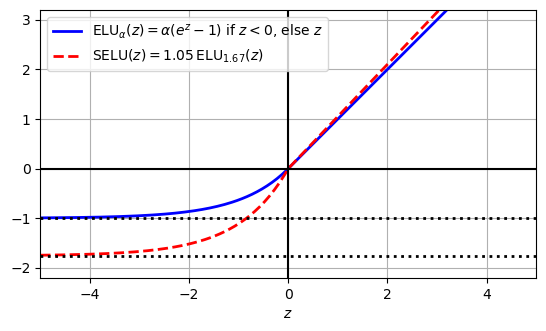

In [10]:
from scipy.special import erfc

# 互补误差函数 erfc(z)：它计算的是从 z 到无穷大的高斯分布曲线下的面积。
# SELU 函数的参数 alpha 和 scale 的推导过程复杂，涉及到确保输出均值为 0、方差为 1 的积分计算。这些积分的形式与高斯分布密切相关，因此自然就会用到 erfc 函数。
# 代码中的 alpha_0_1 和 scale_0_1 的复杂表达式是这些积分计算的结果。
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [1]:
import tensorflow as tf

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [2]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [6]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 12ms/step - loss: 1.0817 - accuracy: 0.5964 - val_loss: 0.9169 - val_accuracy: 0.6936
Epoch 2/5
1719/1719 [==============================] - 20s 11ms/step - loss: 1.0651 - accuracy: 0.6112 - val_loss: 0.9087 - val_accuracy: 0.6630
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7705 - accuracy: 0.7107 - val_loss: 0.6405 - val_accuracy: 0.7644
Epoch 4/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.6460 - accuracy: 0.7602 - val_loss: 0.5792 - val_accuracy: 0.7878
Epoch 5/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.5723 - accuracy: 0.7906 - val_loss: 0.5524 - val_accuracy: 0.7930


In [7]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [8]:
# 使用relu学习效果不好，遇到了梯度消失/爆炸的问题， Selu避免了这个问题

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 10ms/step - loss: 2.1904 - accuracy: 0.1671 - val_loss: 2.5639 - val_accuracy: 0.1554
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.5627 - accuracy: 0.3521 - val_loss: 1.3026 - val_accuracy: 0.4226
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.0789 - accuracy: 0.5537 - val_loss: 1.1081 - val_accuracy: 0.5780
Epoch 4/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8924 - accuracy: 0.6428 - val_loss: 0.9461 - val_accuracy: 0.6006
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8282 - accuracy: 0.6642 - val_loss: 1.5407 - val_accuracy: 0.4474


#### GELU, Swish和Mish

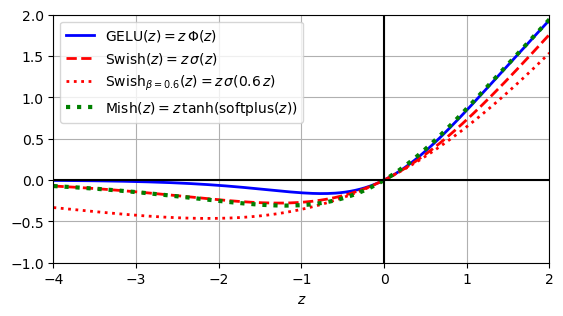

In [25]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")


plt.show()

GELU在2016年引入。同样，可以将其视为ReLU激活函数的平滑实体。其定义在公式中给出，其中$\Phi$是标准高斯累积分布函数(CDF)：$\Phi(z)$对应于从均值为0、方差为1的正态分布中随机采样的值低于z的概率。

**公式：GELU激活函数**

$$
\text{GELU}(z) = z\Phi(z)
$$

如上图所示，GELU类似于ReLU：当其输入$z$为负时，它接近于0；当z为正时，它接近z。然而，尽管我们目前讨论的所有激活函数都是凸函数和单调函数，但GELU激活函数两者都不是：从左到右，它从直线开始，然后向下摆动，到达附近的低点-0.17（接近z < -0.75），最后弹起并最终直奔右上角。

这种相当复杂的形状以及它在每个点都有曲率的事实可以解释为什么它工作得如此好，特别是对于复杂的任务：梯度下降可能会发现它更容易适应复杂的模式。在实践中，它通常优于目前讨论的所有其他激活函数。

然而，它的计算量更大一些，而且它的性能提升并不总是足以证明出额外代价的合理性。也就是说，可以证明它近似等于$z\sigma(1.702z)$，其中$\sigma$是sigmoid函数：使用这种近似值也很有效，而且它的优点是计算速度快得多。

GELU论文还引入了sigmoid线性单元(SiLU)激活函数，它等于 $z\sigma(z)$，但在作者的测试中已被GELU超越了。有趣的是，其他人在2017年发表的论文中中通过自动搜索好的激活函数重新发现了SiLU函数。作者将其命名为**Swish**，并且这个名字流行了起来。

在他们的论文中，Swish优于其他所有函数，包括GELU。Ramachandran等人后来通过添加额外的超参数$\beta$来缩放sigmoid函数的输入，从而泛化了Swish。广义Swish函数为 $\text{Swish}_\beta(z) = z\sigma(\beta z)$，因此GELU近似等于使用$\beta = 1.702$的广义Swish函数。

可以像调整任何其他超参数一样调整$\beta$。你也可以使$\beta$可以通过梯度下降对其进行优化：与PReLU非常相似，这可以使模型更强大，但它也存在过度拟合数据的风险。

另一个非常相似的激活函数是**Mish**，它是在2019年发表的论文中介绍的。它被定义为 $\text{Mish}(z) = z\tanh(\text{softplus}(z))$，其中 $\text{softplus}(z) = \log(1 + \exp(z))$。

就像GELU和Swish一样，它是ReLU的平滑、非凸和非单调变体。同样，作者进行了许多实验，发现Mish通常优于其他激活函数——即使是Swish和GELU，有微小的差距。

上图示了GELU、Swish（默认$\beta = 1$和$\beta = 0.6$），以及Mish激活函数。当$z$为负时，Mish与Swish几乎完美重叠，而当$z$为正时，与GELU几乎完美重叠。

应该为深度神经网络的隐藏层使用哪种激活函数呢？

- ReLU仍然是简单任务的良好默认选择：它通常与更复杂的激活函数一样好，而且计算速度非常快，许多库和硬件加速器提供特定于ReLU的优化方式。
- 但是，对于复杂的任务，Swish可能是更好的默认设置，
- 对于非常复杂的任务，甚至可以尝试使用具有可学习的β参数的参数化Swish。Mish可能会带来更好的结果，但它需要更多的计算量。
- 如果你非常关心运行时延迟，那可能更喜欢leaky ReLU，或者适合复杂任务的参数化leaky ReLU。
- 对于深度MLP，请尝试使用SELU，但请确保遵守前面列出的约束。
- 如果你有空闲时间和计算能力，也可以使用交叉验证来评估其他激活函数。

Keras开箱即用地支持GELU和Swish；只需使用activation="gelu"或activation="swish"。但是，它还不支持Mish或广义的Swish激活函数 （后续会学自定义激活函数和层）

In [9]:
# 随堂练习：尝试使用gelu/swish / 参数化的leak relu(tf.keras.layers.PReLU)

# leaky_relu(z) = max(az, z)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # 激活函数作为一个独立的层
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
    tf.keras.layers.PReLU(),  # 激活函数作为一个独立的层
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_202 (Dense)           (None, 50)                39250     
                                                                 
 p_re_lu (PReLU)             (None, 50)                50        
                                                                 
 dense_203 (Dense)           (None, 50)                2550      
                                                                 
 p_re_lu_1 (PReLU)           (None, 50)                50        
                                                                 
 dense_204 (Dense)           (None, 10)                510       
                                                                 
Total params: 42410 (165.66 KB)
Trainable params: 4241

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0246 - accuracy: 0.6674 - val_loss: 0.6798 - val_accuracy: 0.7696
Epoch 2/5
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6242 - accuracy: 0.7839 - val_loss: 0.5610 - val_accuracy: 0.8014
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5425 - accuracy: 0.8087 - val_loss: 0.5109 - val_accuracy: 0.8158
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4998 - accuracy: 0.8231 - val_loss: 0.4824 - val_accuracy: 0.8268
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4723 - accuracy: 0.8327 - val_loss: 0.4619 - val_accuracy: 0.8334


### 批量归一化

尽管将 He 初始化与 ReLU（或其任何变体）一起使用可以显著降低在训练开始时出现梯度消失/爆炸问题的风险，但这并不能保证它们在训练期间不会再出现。

在2015年提出了一种称为**批量归一化（Batch Normalization，BN）** 的技术来解决这些问题。该技术包括在模型中每个隐藏层的激活函数之前或之后添加一个操作。该操作对每个输入进行零中心化并归一化，然后在每层使用两个新的参数向量缩放并偏移其结果：一个用于缩放，另一个用于偏移。换句话说，该操作可以使模型学习各层输入的最佳缩放和均值。在许多情况下，如果将 BN 层添加为神经网络的第一层，则无须归一化训练集（也就是说，不需要使用 `StandardScaler` 或 `Normalization`），BN 层会为你完成此操作（因为它一次只能查看一个批次，它还可以重新缩放和偏移每个输入特征）。

为了使输入零中心化并归一化，该算法需要估计每个输入的均值和标准差。我们通过评估当前小批次上的输入的均值和标准差（因此称为“批量归一化”）来实现。下面公式逐步总结了整个操作。

**公式：批量归一化算法**

1. $$\mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} \mathbf{x}^{(i)}$$
2. $$\sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (\mathbf{x}^{(i)} - \mu_B)^2$$
3. $$\hat{\mathbf{x}}^{(i)} = \frac{\mathbf{x}^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
4. $$\mathbf{z}^{(i)} = \boldsymbol{\gamma} \otimes \hat{\mathbf{x}}^{(i)} + \boldsymbol{\beta}$$

在此算法中：

- $\mu_B$ 是输入均值的向量，在整个小批次 $B$ 上评估（每个输入包含一个均值）。
- $m_B$ 是小批次中的实例数量。
- $\sigma_B$ 是输入标准差的向量，也在整个小批次上评估（每个输入包含一个标准差）。
- $\epsilon$ 是一个平滑项，用于避免除以零（通常取一个很小的值，例如 $10^{-5}$）。
- $\boldsymbol{\gamma}$ 是层的缩放参数向量（每个输入包含一个缩放参数）。
- $\boldsymbol{\beta}$ 是层的偏移参数向量（每个输入包含一个缩放参数    ）。
- $\otimes$ 表示逐元素乘法（每个输入乘以其相应的输出缩放参数）。
- $\mathbf{z}^{(i)}$ 是 BN 操作的输出，将传递给下一层或激活函数。

因此在训练期间，BN操作会归一化其输入，然后重新缩放并偏移它们。

那在测试期间，可能需要对单个实例而不是批量的实例进行预测：在这种情况下，无法计算每个输入的均值和标准差。而且，即使确实有一批实例，它也可能太小，或者这些实例可能不是独立同分布的，因此在这批实例上计算统计信息是不可靠的

一种解决方法是等到训练结束，然后通过神经网络运行整个训练集，计算BN层每个输入的均值和标准差。然后，在进行预测时，可以使用这些“最终”的输入均值和标准差，而不是批量输入的均值和标准差

然而，大多数批量归一化的实现都通过该层输入的均值和标准差的移动平均值来估计训练期间的最终统计信息。这是Keras在使用BatchNormalization层时自动执行的操作

综上所述，在每个批量归一化层中学习四个参数向量：通过常规反向传播学习γ（输出缩放向量）和β（输出偏移向量），使用指数移动平均值估计μ（最终输入均值向量）和σ（最终输入标准差向量）。请注意，μ和σ是在训练期间估算的，但仅在训练后使用（以替换公式中的批量输入均值和标准差）。

研究者已证明批量归一化极大地改善了他们实验过的所有深度神经网络，从而极大地提高了ImageNet分类任务的性能（ImageNet是将图像分类为许多类的大型图像数据库，通常用于评估计算机视觉系统）。梯度消失的问题已大大减少，以至于可以使用饱和的激活函数，例如tanh甚至sigmoid激活函数。网络对权重初始化也不太敏感。作者可以使用更大的学习率，大大加快了学习过程。他们特别指出：

"将批量归一化应用于最先进的图像分类模型，用原来14分之一的训练步骤即可达到相同的精度，在很大程度上击败了原始模型。......使用批量归一化网络的集成网络，我们在ImageNet分类中改进了已发布的最好结果：前5位的验证错误达到了4.9%（测试错误达到4.8%）​，超过了人工评分者的精度。"

In [29]:
# 随堂练习：用python设计一个移动平均的操作，每次可以接收一个数组，然后根据数组，更新整体平均值

class MovingAverage:
    def __init__(self):
        self.count = 0
        self.average = None

    def __call__(self, new_batch):
        # new_average = (sum(new_batch)  + self.count*self.average) / (self.count + 批次的长度）
        #  self.count += 批次的长度
        # self.average = new_average
        # return self.average
        if self.average is None:
            self.average = sum(new_batch) / len(new_batch)
            self.count = len(new_batch)
            return self.average

        avg_batch = sum(new_batch) / len(new_batch)
        momentum = self.count / (self.count + len(new_batch))
        new_average = momentum * self.average + (1 - momentum) * avg_batch
        #   new_average = avg(new_batch) * (1-u) + u*当前平均值  （0<u<1)
        self.count += len(new_batch)
        self.average = new_average
        return new_average

move_avg = MovingAverage()
move_avg([1,2]) # -> 1.5
move_avg([3,4,5])# -> 3.0
move_avg([3,4,5])

3.375

最后，批量归一化的作用之一就是正则化，大大减少了对其他正则化技术（如 dropout，本章稍后将介绍）的需求。

但是，批量归一化确实增加了模型的复杂度（尽管它可以消除对输入数据进行归一化的需求，正如前面所讨论的）。此外，还有运行时间的损失：由于每一层都需要进行额外的计算，因此神经网络的预测速度较慢。幸运的是，我们经常可以在训练后将 BN 层与上一层融合，从而避免运行时间的损失。方法是更新前一层的权重和偏置项，以便它直接产生适当的缩放和偏移的输出。例如，如果前一层计算 $XW + b$，那么 BN 层将计算 $\boldsymbol{\gamma} \otimes (XW + b - \boldsymbol{\mu}) / \boldsymbol{\sigma} + \boldsymbol{\beta}$（忽略分母中的平滑项 $\epsilon$）。如果我们定义 $W' = \boldsymbol{\gamma} \otimes W / \boldsymbol{\sigma}$ 和 $b' = \boldsymbol{\gamma} \otimes (b - \boldsymbol{\mu}) / \boldsymbol{\sigma} + \boldsymbol{\beta}$，那么前一层可以直接计算 $XW' + b'$ 来得到与原始计算（$XW + b$ 后接 BN 层）相同的输出。 因此用更新后的W'和b'替换W和b就可以去掉BN层

可能会发现训练速度相当慢，因为使用批量归一化时每轮(epoch)要花费更多时间。通常情况下，这会被BN的快速收敛速度而抵消，因此达到相同性能所需的轮次更少，总而言之，所消耗的总时间通常会更短。

#### 用Keras实现批量归一化

与使用Keras的大多数任务操作一样，实施批量归一化非常简单，只需在每个隐藏层的激活函数之前或之后添加一个BatchNormalization层。也可以添加一个BN层作为模型的第一层，但是普通的Normalization层在这个位置通常也表现得非常好（它唯一的缺点是必须首先调用它的adapt()方法）。例如，此模型在每个隐藏层之后应用BN,并将其作为模型的第一层（展平层之后)

In [21]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# 只有两个隐藏层的示例中，批量归一化不会产生什么影响，但是对于更深层的网络，它可以产生巨大的影响

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_205 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_206 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

每个 BN 层为每个输入添加了四个参数向量：γ、β、μ 和 σ
（例如，第一个 BN 层添加了 3136 个参数，即 4×784）。

最后两个参数向量 μ 和 σ 是移动平均值。它们不受反向传播的影响，因此 Keras 称其为“不可训练”参数。

如果你计算 BN 参数的总数：3136 + 1200 + 400，然后除以 2，则得到 2368，即此模型中不可训练参数的总数

注意：平均值和标准差是在训练期间根据训练数据估计的，因为可以说它们是可训练的。在Keras中，"不可训练"的真正意思是不受反向传播的影响

In [24]:
# 第一个BN层的参数，两个是可训练的（受反向传播影响），两个不是
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

BN论文的作者主张在激活函数之前而不是之后（就像刚刚的代码）添加BN层。对此存在一些争论，因为哪个更可取似乎取决于任务——也可以对此进行实验，看看哪个选择最适合自己的数据集。要在激活函数之前添加BN层，必须从隐藏层中移除激活函数，并将它们作为单独的层添加到BN层之后。此外，由于批量归一化层的每个输入都包含一个偏移参数，因此你可以在创建它时传递use_bias=False，从上一层中删除偏置项。最后，通常可以删除第一个BN层以避免将第一个隐藏层夹在两个BN层之间，更新后的代码如下所示：

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_208 (Dense)           (None, 300)               235200    
                                                                 
 batch_normalization_3 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_209 (Dense)           (None, 100)               30000     
                                                                 
 batch_normalization_4 (Bat  (None, 100)               400       
 chNormalization)                                     

In [27]:
# 展示批量归一化的效果
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6087 - accuracy: 0.7960 - val_loss: 0.4301 - val_accuracy: 0.8460
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4236 - accuracy: 0.8515 - val_loss: 0.3738 - val_accuracy: 0.8628


BatchNormalization类有可以调整的超参数，比如可以调整动量（momentum）。

BatchNormalization 层在更新指数移动平均值时使用此超参数。
给定一个新值 $u$（即在当前批次中计算的输入均值或标准差的新向量），该层使用以下公式来更新运行平均值 $\hat{u}$：

$$
\hat{u} \leftarrow \hat{u} \times momentum + u \times (1 - momentum)
$$

良好的动量值通常接近 1，例如 0.9、0.99 或 0.999。
对于较大的数据集和较小的批处理，需要的 9 更多。

另一个重要的超参数是轴 (axis)：它确定哪个轴应该被归一化。默认值为 -1，这意味着默认情况下它将对最后一个轴进行归一化（使用在其他轴计算得到的均值和标准差）。

当输入批次为 2D（即批次形状为 [批次大小, 特征]）时，这意味着将基于在此批次中所有实例上计算得到的均值和标准差对每个输入特征进行归一化。
例如，先前代码示例中的第一个 BN 层将独立地归一化（重新缩放和偏移）784 个输入特征中的每一个。

如果将第一个 BN 层移动到 Flatten 层之前，则输入批次将为 3D，形状为 [批次大小, 高度, 宽度]，因此，BN 层将计算 28 个均值和 28 个标准差（每列像素 1 个，在批次的所有实例以及列中所有行之间计算），它将使用相同的均值和标准差对给定列的所有像素进行归一化。也将有 28 个缩放参数和 28 个偏移参数。

如果仍然要独立地处理 784 个像素中的每一个，则应设置 axis=[1, 2]。


批量归一化已经成为深度神经网络中常用的一层，尤其是后面学习的深度卷积神经网络（CNN），以至于在架构图中它经常被省略：假设已经在每一层之后添加了 BN。


### 梯度裁剪

最后一种在训练期间稳定梯度的技术：梯度裁剪，在反向传播过程中裁剪梯度，使它们永远不会超过某个阈值。这种技术通常用于循环神经网络（RNN），它很难使用批量归一化

在Keras中，实现梯度裁剪只是在创建优化器时设置clipvalue或clipnorm参数

In [9]:
# optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

该优化器会将梯度向量的每个分量都裁剪为-1.0～1.0之间的值。这意味着损失函数的所有偏导数（相对于每个可训练的参数）将限制在-1.0～1.0之间。阈值是可以调整的超参数。

注意，它可能会改变梯度向量的方向。例如，如果原始梯度向量为[0.9，100.0]，则其主要指向第二个轴的方向，但是按值裁剪后，将得到[0.9，1.0]，这将大致指向两个轴之间的对角线。实际上，这种方法非常有效。

如果要确保“梯度裁剪”不更改梯度向量的方向，那么应该通过设置clipnorm而不是clipvalue来按照范数裁剪。如果ℓ2范数大于选择的阈值，则会裁剪整个梯度。例如，如果设置clipnorm=1.0，则向量[0.9，100.0]将被裁剪为[0.00899964，0.9999595]，它保留了方向，但几乎消除了第一个分量。

如果在训练期间观察到梯度爆炸（可以使用TensorBoard跟踪梯度的大小），可能想使用不同的阈值尝试按值裁剪或按范数裁剪，看看哪种在验证集上表现最好。

## 重用预训练层

如果不先尝试找到一个现有的神经网络——该神经网络可以完成与你要处理的任务类似的任务，就从头开始训练非常大的DNN，这通常不是一个好主意。如果能够找到这样的神经网络，那么通常可以重用它的大部分层，除了最上面的层。这种技术称为迁移学习。

它不仅会大大加快训练速度，而且需要的训练数据也会大大减少。假设你可以访问一个训练过的DNN，它能分类100种不同类别的图像，其中包括动物、植物、车辆和日常物品，现在想训练该DNN来对特定类型的车辆进行分类。这些任务非常相似，甚至有部分重叠，因此应该尝试重用第一个网络的一部分

![重用预训练层](./images/neural_network/p10.png)

如果新任务的输入图像的大小与原始任务中使用的图像不同，通常必须添加预处理步骤将其调整为原始模型所需的大小。一般而言，当输入具有类似的低级特征时，迁移学习最有效。

通常应该替换掉原始模型的输出层，因为它对于新任务而言很有可能根本没有用，甚至对于新任务而言，可能没有准确数量的输出。

类似地，原始模型上面的隐藏层不太可能像下面的那样有用，因为对新任务最有用的高级特征可能与对原始任务最有用的特征有很大的不同。需要确定要重用的具体层数。

任务越相似，可重用的层越多（从较低的层开始）​。对于非常相似的任务，请尝试保留所有的隐藏层，只替换掉输出层。

首先尝试冻结所有可重用的层（即使它们的权重不可训练，以便梯度下降不会修改它们并且它们将保持固定），训练模型并查看其表现。然后尝试解冻上面隐藏层中的一两层，使反向传播可以对其进行调整，再查看性能是否有所提高。拥有的训练数据越多，可以解冻的层就越多。当解冻重用层时，降低学习率也很有用：这可以避免破坏其已经调整好的权重。

如果仍然无法获得良好的性能，并且训练数据很少，那么试着去掉顶部的隐藏层，然后再次冻结其余所有的隐藏层。不断迭代，直到找到合适的可以重用的层数。如果有大量的训练数据，则可以尝试替换顶部的隐藏层而不是去掉它们，甚至可以添加更多的隐藏层。

### 用Keras进行迁移学习

将Fashion MNIST训练集拆分为两部分：

- **X_train_A**：包含除T恤/上衣和套头衫（类别0和2）之外的所有物品图像。
- **X_train_B**：仅包含前200张T恤/上衣和套头衫图像的小型训练集。

验证集和测试集也按此方式划分，但不限制图像数量。

将在数据集A（8分类任务）上训练模型，并尝试将其复用至数据集B（二分类任务）。由于数据集A中的类别（裤子、连衣裙、外套、凉鞋、衬衫、运动鞋、包和短靴）与数据集B中的类别（T恤/上衣和套头衫）具有一定相似性，期望能够实现一定程度的知识迁移。但需要注意的是，由于使用的是全连接层，只有相同位置出现的模式才能被复用（相比之下，卷积层的迁移效果会好得多，因为学习到的模式可以在图像任意位置被检测到，将在卷积神经网络详细讨论）。

In [14]:
# 将Fashion MNIST分成 任务A和任务B，然后训练和 保存my_model_A
import numpy as np
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("./models/my_model_A.keras")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.2265 - accuracy: 0.6025 - val_loss: 0.7321 - val_accuracy: 0.7556
Epoch 2/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.6294 - accuracy: 0.7898 - val_loss: 0.5437 - val_accuracy: 0.8120
Epoch 3/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.5063 - accuracy: 0.8342 - val_loss: 0.4630 - val_accuracy: 0.8456
Epoch 4/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.4416 - accuracy: 0.8551 - val_loss: 0.4142 - val_accuracy: 0.8589
Epoch 5/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.4005 - accuracy: 0.8672 - val_loss: 0.3812 - val_accuracy: 0.8666
Epoch 6/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.3717 - accuracy: 0.8763 - val_loss: 0.3580 - val_accuracy: 0.8726
Epoch 7/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.3511 - accuracy: 0.8824 - val_loss: 0.3423 - val_accuracy:

In [15]:
# 不用model_A, 从头训练和评估modelA
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 25ms/step - loss: 0.6834 - accuracy: 0.6000 - val_loss: 0.6727 - val_accuracy: 0.5816
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6362 - accuracy: 0.6750 - val_loss: 0.6338 - val_accuracy: 0.6944
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.6012 - accuracy: 0.7800 - val_loss: 0.6040 - val_accuracy: 0.7596
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5696 - accuracy: 0.8400 - val_loss: 0.5771 - val_accuracy: 0.8140
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5435 - accuracy: 0.9000 - val_loss: 0.5512 - val_accuracy: 0.8467
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5181 - accuracy: 0.9200 - val_loss: 0.5282 - val_accuracy: 0.8694
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4952 - accuracy: 0.9250 - val_loss: 0.5074 - val_accuracy: 0.8793
Epoch 8/20
7/7 [===============

[0.3633973300457001, 0.9275000095367432]

现在试下复用预训练过的模型A

In [16]:
model_A = tf.keras.models.load_model("./models/my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# 需要注意的是，由于 model_B_on_A 和 model_A 现在共享网络层，因此当训练其中一个模型时，另一个模型的参数也会同步更新。若需避免此情况，我们需要基于 model_A 的克隆结构来构建 model_B_on_A。

In [ ]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())  # tf.keras.models.clone_model()只复制架构，不复制权重。如果不使用set_weights手动复制它们，它们将在首次使用复制的模型时随机初始化

现在你可以为任务B训练model_B_on_A，但是由于新的输出层是随机初始化的，它会产生较大的错误（至少在前几个轮次内），因此将存在较大的错误梯度，这可能会破坏重用的权重。为了避免这种情况，一种方法是在前几个轮次时冻结重用的层，给新层一些时间来学习合理的权重。为此，将每一层的trainable属性设置为False并编译模型：

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# 冻结或者解冻层后，必须要编译模型
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

将模型训练几个轮次，然后解冻重用的层（这需要再次编译模型），并继续进行训练以基于任务B来微调重用层。解冻重用层之后，降低学习率通常可以再次避免损坏重用权重：

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# 冻结或者解冻层后，必须要编译模型
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

实践证明，迁移学习在小型密集网络中不能很好地工作，大概是因为小型网络能学习的模式很少，密集网络学习的是非常具体的模式，这在其他任务中不是很有用。迁移学习最适合用于深度卷积神经网络，后者倾向于学习更为通用的特征检测器（尤其是在较低层）。将在卷积神经网络中使用刚刚讨论的技术重新审视迁移学习

### 无监督预训练